In [2]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.signal import place_poles
from scipy.signal import find_peaks


from plotfunc import plot_sets

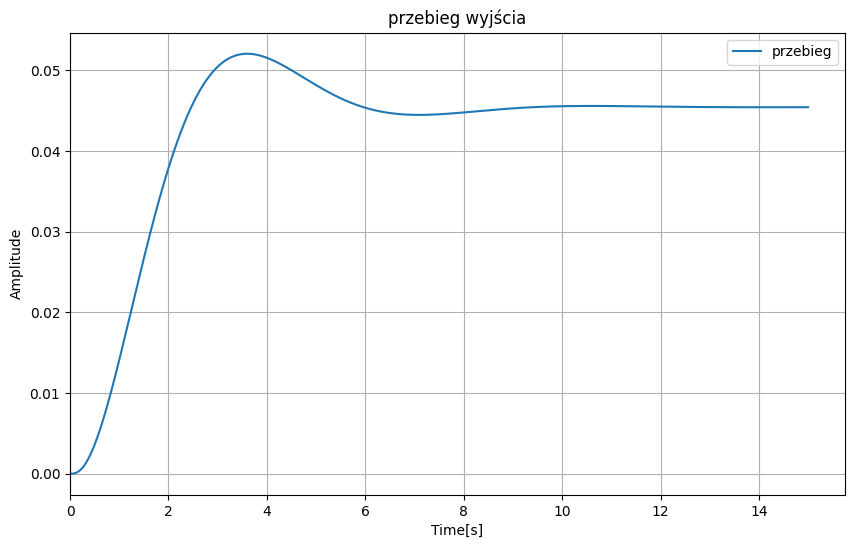

In [5]:
def model(x,t):
    R1=2
    R2=5
    C1=0.5
    L1=2
    L2=0.5

    u=np.array([[1]])

    A=np.array([[-R1/L1,0,-1/L1],[0,-R2/L2,1/L1],[1/C1,-1/C1,0]])
    B=np.array([[1/L1],[0],[0]])
    C=np.array([[0,1,0]])
    D=0

    dx=A@x+(B*u).flatten()
    return dx

x0 = np.array([0, 0, 0])  # [i1, i2, uc]

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])


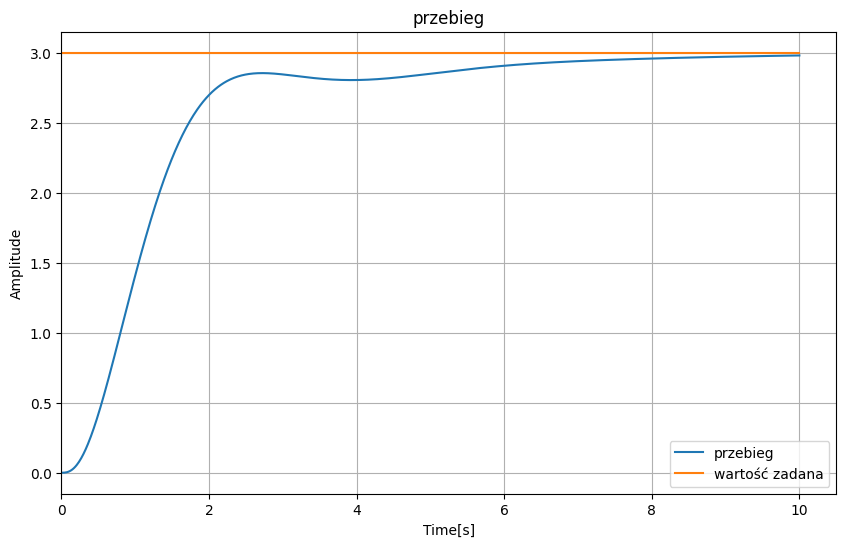

In [4]:
def model_with_pid(x, t, kp, ki, kd, yd):
    R1, R2 = 2, 5
    L1, L2 = 2, 0.5
    C1 = 0.5
    
    # Rozdzielenie stanu
    i1, i2, uc = x[0], x[1], x[2]
    integral_e = x[3]  # całka z błędu
    
    # Macierze układu
    A = np.array([[-R1/L1, 0, -1/L1],
                  [0, -R2/L2, 1/L2],
                  [1/C1, -1/C1, 0]])
    B = np.array([1/L1, 0, 0])
    C = np.array([0, 1, 0])  # y = i2
    
    y = C @ np.array([i1, i2, uc])
    
    e = yd - y

    dy_dt = C @ (A @ np.array([i1, i2, uc]))
    de_dt = -dy_dt
    
    u = kp * e + ki * integral_e + kd * de_dt
    
    dx_plant = A @ np.array([i1, i2, uc]) + B * u
    
    d_integral_e = e
    
    return [dx_plant[0], dx_plant[1], dx_plant[2], d_integral_e]

# Parametry regulatora PID
kp = 10 #30 te fajne 
ki = 5 #10
kd = 5 #15
yd = 3  # wartość zadana

x0 = np.array([0, 0, 0, 0])

t = np.linspace(0, 10, 1000)
wartosc_zad = np.ones(1000)*3

x1 = odeint(model_with_pid, x0, t, args=(kp, ki, kd, yd))

y = x1[:, 1]

plot_sets('przebieg',[t,y,'przebieg'],[t,wartosc_zad,'wartość zadana'])

# zigler nichols


Okres oscylacji (Tu) = 1.6216


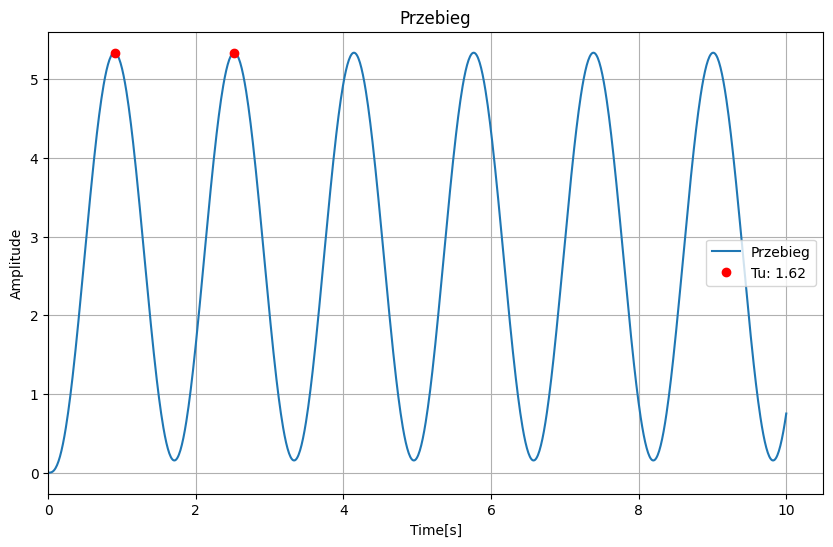

In [ ]:
# Parametry regulatora PID
kp = 75.5   # ku =75 kp=0.6ku=45
ki = 0      # Tu approx 2,12 ki=1.2kuTu^-1=
kd = 0      # kd =0.075kuTu=9
yd = 3  # wartość zadana

x0 = np.array([0, 0, 0, 0])

t = np.linspace(0, 10, 1000)

x1 = odeint(model_with_pid, x0, t, args=(kp, ki, kd, yd))

y = x1[:, 1]

def plot_sets(name, *data_sets):
    plt.figure(figsize=(10, 6))
    plt.title(name)
    for ds in data_sets:
        t, x, title = ds[:3]
        style = ds[3] if len(ds) > 3 else '-'
        plt.plot(t, x, style, label=title)
    plt.xlabel("Time[s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.xlim(left=0)
    plt.show()

peaks, _ = find_peaks(y)
if len(peaks) > 1:
    Tu = np.mean(np.diff(t[peaks]))
    print(f"Okres oscylacji (Tu) = {Tu:.4f}")
else:
    print("Zbyt mało pików, aby obliczyć okres. Zwiększ czas symulacji lub wzmocnienie.")

plot_sets('Przebieg', [t, y, 'ku=75.5'], [t[peaks[:2]], y[peaks[:2]], f'Tu: {Tu:.2f}', 'ro'])

## model z wskaznikami calkowymi 

In [ ]:
def model_with_pid_integralquality(x,t, yd, Kp, Ki, Kd, q, r):
    R1, R2 = 2, 5
    L1, L2 = 2, 0.5
    C1 = 0.5

    x_sys = x[:3]

    integral_e = x[3]
    integral_e2 = x[4]
    integral_te2 = x[5]
    integral_abs_e = x[6]
    integral_t_abs_e = x[7]
    integral_qe2_ru2 = x[8]
    

    A = np.array([[-R1/L1, 0, -1/L1], [0, -R2/L2, 1/L1], [1/C1, -1/C1, 0]])
    B = np.array([[1/L1], [0], [0]])
    C = np.array([[0, 1, 0]])
    D = 0

    y = C @ x_sys

    dxdt = A @ x_sys

    dydt = C @ dxdt

    e = yd - y
    dedt = -dydt

    u = Kp*e + Ki*integral_e + Kd*dedt

    dxdt_sys = A @ x_sys + (B * u).flatten()

    dintegral_e = e[0]
    dintegral_e2 = e[0]**2
    dintegral_te2 = t*e[0]**2
    dintegral_abs_e = abs(e[0])
    dintegral_t_abs_e = t*abs(e[0])
    dintegral_qe2_ru2 = q*e[0]**2 + r*u[0]**2

    return np.concatenate((dxdt_sys, [dintegral_e],[dintegral_e2],[dintegral_te2],[dintegral_abs_e],[dintegral_t_abs_e],[dintegral_qe2_ru2]))

## wskazniki z nastawami empirycznymi

IISE = 9.077985273586643
IITSE = 8.836605878953998
IIAE = 6.599396400214317
IITAE = 22.593190390493458
IOPT = 165744.74771399444


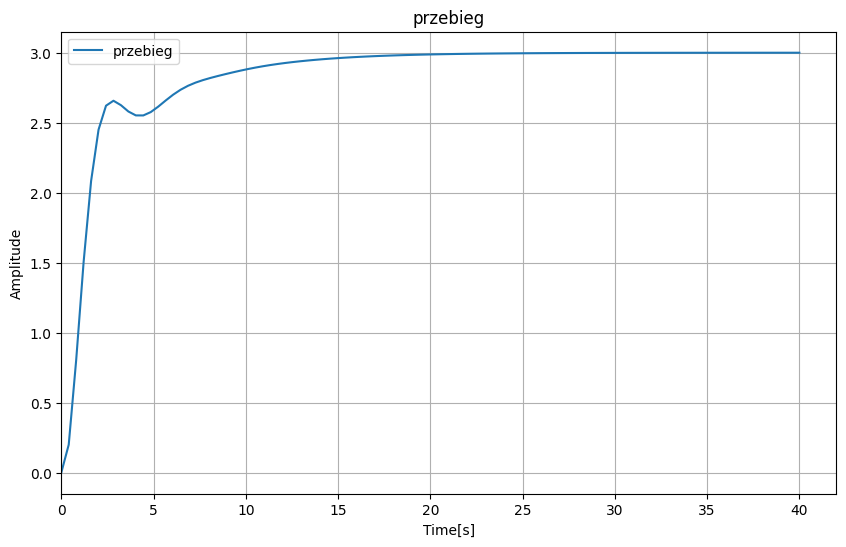

In [32]:
x = np.zeros(9)
t = np.linspace(0, 40, 100)

q = 1
r = 1

Kp = 30
Ki = 10
Kd = 15

# Kp = 40
# Ki = 19
# Kd = 30
# IOPT = 18052.284035498407

x_sol = odeint(model_with_pid_integralquality, x, t, args=(yd, Kp, Ki, Kd, q, r))
y_sol = x_sol[:, 1]

# ostatni wiersz - indeks kolumny
IISE = x_sol[-1, 4]
IITSE = x_sol[-1, 5]
IIAE = x_sol[-1, 6]
IITAE = x_sol[-1, 7]
IOPT = x_sol[-1, 8]


print("IISE =", IISE)
print("IITSE =", IITSE)
print("IIAE =", IIAE)
print("IITAE =", IITAE)
print("IOPT =", IOPT)

plot_sets('przebieg',[t,y_sol,"przebieg"])

## wskazniki z ziglerem 


In [41]:
x = np.zeros(9)
t = np.linspace(0, 40, 100)
wartosc_zad = np.ones(100)*3

q1 = 1
r1= 0.01
Kp1 = 45     # ku =75 kp=0.6ku=45
Ki1= 56.6      # Tu approx 2,12 ki=1.2kuTu^-1=
Kd1 = 9

x_sol1 = odeint(model_with_pid_integralquality, x, t, args=(yd, Kp1, Ki1, Kd1, q1, r1))
y_sol1 = x_sol1[:, 1]

q2 = 1
r2= 0.01
Kp2 = 100    # ku =75 kp=0.6ku=45
Ki2= 40      # Tu approx 2,12 ki=1.2kuTu^-1=
Kd2 = 35

x_sol2 = odeint(model_with_pid_integralquality, x, t, args=(yd, Kp2, Ki2, Kd2, q2, r2))
y_sol2 = x_sol2[:, 1]

q3 = 1
r3= 1
Kp3 = 20    # ku =75 kp=0.6ku=45
Ki3= 40      # Tu approx 2,12 ki=1.2kuTu^-1=
Kd3 = 60

x_sol = odeint(model_with_pid_integralquality, x, t, args=(yd, Kp3, Ki3, Kd3, q3, r3))
y_sol = x_sol[:, 1]

# ostatni wiersz - indeks kolumny
IISE = x_sol[-1, 4]
IITSE = x_sol[-1, 5]
IIAE = x_sol[-1, 6]
IITAE = x_sol[-1, 7]
IOPT = x_sol[-1, 8]

print("IISE =", IISE)
print("IITSE =", IITSE)
print("IIAE =", IIAE)
print("IITAE =", IITAE)
print("IOPT =", IOPT)

plot_sets('przebieg',[t,wartosc_zad,'wartość zadana'],[t,y_sol1,"ZG"],[t,y_sol2,"szybki"],[t,y_sol,"wolny"])

NameError: name 'integral_e' is not defined

In [1]:
# PID Parameters from table
# Regulator | kp     | ki     | kd
# P         | 37.75  | -      | -
# PI        | 33.975 | 25.16  | -
# PD        | 60.4   | -      | 12.231
# PID       | 45.3   | 55.926 | 9.17325

pid_params = [
    {"name": "P", "kp": 37.75, "ki": 0, "kd": 0},
    {"name": "PI", "kp": 33.975, "ki": 25.16, "kd": 0},
    {"name": "PD", "kp": 60.4, "ki": 0, "kd": 12.231},
    {"name": "PID", "kp": 45.3, "ki": 55.926, "kd": 9.17325}
]

yd = 3
t = np.linspace(0, 10, 1000)
x0 = np.array([0, 0, 0, 0]) # [i1, i2, uc, integral_e]

plot_data = []

# Run simulations
for params in pid_params:
    kp = params["kp"]
    ki = params["ki"]
    kd = params["kd"]
    
    x_sol = odeint(model_with_pid, x0, t, args=(kp, ki, kd, yd))
    y = x_sol[:, 1]
    
    plot_data.append([t, y, params["name"]])

# Add target value to plot data
yd_vector = np.ones_like(t) * yd
plot_data.append([t, yd_vector, "Target yd"])

plot_sets('PID Simulations', *plot_data)

NameError: name 'np' is not defined